In [2]:
import scraper.guardian_dataset as corpus

In [3]:
import torch
from matplotlib import pyplot as plt
import numpy
from tqdm.notebook import tqdm, trange

In [4]:
#Just to grab a bunch of random words that might fit into groups
article = corpus.getArticle('https://www.theguardian.com/world/2020/sep/13/us-west-coast-choked-by-smoke-as-firefighters-tackle-deadly-wildfires')

In [5]:
vec_article = list()
for word in tqdm(article):
    try:
        word = corpus.w2v[word]
        vec_article.append(torch.from_numpy(word))
    except KeyError:
        pass
article = vec_article
del vec_article

<ipython-input-5-6876257344bb>:5: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629395347/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  vec_article.append(torch.from_numpy(word))


In [6]:
#Now comes time to rank each of the articles
ranked = list()
for word in article:
    sort_article = sorted(article, key=lambda w : torch.cosine_similarity(w, word, dim=0), reverse=False)
    ranked.append({"word":word, "rankings":sort_article})

In [7]:
#Lets prove the algo first:
test = ranked[0]

In [8]:
distances = [torch.cosine_similarity(w, test['word'], -1).item() for w in test['rankings']]
distances = [i  for i in filter(lambda x: x!= 1, distances)]#Get rid of the same word, cause that messes up the scale

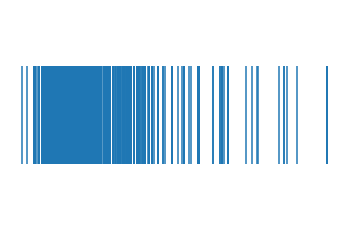

In [9]:
#taking a quick look to prove that clear groupings exist
%matplotlib inline 
#Kinda hard to see inline, need a larger output, i made it inline for my gh, u should switch it to qt
plt.figure()
# plt.hlines(1, 1, max(distances)/2)
plt.eventplot(distances, orientation="horizontal")
plt.axis('off')
plt.show()

Cool, so its clear that there are groupings. Now how do we actually separate them? It is very easy to do visually, however, it is very difficult to make a general solution that will always work in a computer, as we have to assume inperfection

In order to break up the vectors, we can turn the above graph into a 2 dimensional graph, and use some hack calculus in order to figure out where the groups break off.

# Making frequency graph 2-D

Text(0.5, 0, 'Distance from word')

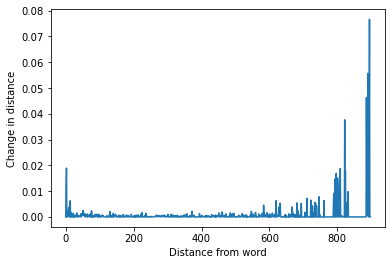

In [10]:
delta_distance = [0]
#Forgive the bad code
for d in range(1, len(distances)):
    delta_distance.append(distances[d] - distances[d-1])
plt.figure()
plt.plot(delta_distance)
plt.ylabel('Change in distance')
plt.xlabel('Distance from word')

Looking at the two above graphs right next to each other, one can see that there are obvious peaks in the 2-d graph between groups! 
Let's try to use these peaks to make groups

In [11]:
groups = list()
start_idx = 0
running_avg = [0 for i in range(6)]
for item in range(0, len(delta_distance)-2):
    running_avg[0:5] = running_avg[1:6]
    running_avg[5] = delta_distance[item+2] - delta_distance[item+1]
    
    if (sum(running_avg)/len(running_avg) < 0 and running_avg[5] < 0):
        groups.append(test['rankings'][start_idx:item])
        start_idx = item + 1

In [12]:
lengths = [len(group) for group in groups]

In [13]:
avg_len = sum(lengths)/len(lengths)
avg_len

4.737179487179487

# Thats a pretty good average size for groups, keep in mind that some words are going to be extraneous, and others are going to have more than average pairings

# Lets see how well these pairings are

In [14]:
sum_dist_total = torch.zeros(1)
counter_total = 0
check = torch.zeros(300) == torch.ones(300)
for group in tqdm(groups):
    for item in group:
        for other in group:
            
            if not torch.all(torch.eq(item, other)):
                sum_dist_total += torch.cosine_similarity(item, other, -1)
                counter_total += 1
                

In [15]:
sum_dist_total/counter_total

tensor([0.2256])

# So the pairings work out pretty well


Now, lets look at the code to execute this on the entire dataset

In [16]:
#Flashing back to above, remember that "ranked" is a list of dictionaries with the properties 'word' and 'ranking'
#Note: for most uses of this algo, you will NOT need to do all of this, only some of the grouping stuff. Therefore it will not take as long to run

output = list()
for word in tqdm(ranked):
    distance = [torch.cosine_similarity(word['word'], i, -1) for i in word['rankings']]
    delta_distance = [0]
    for d in range(1, len(distance)):
        delta_distance.append(distance[d] - distance[d-1])
    groups = list()
    start_idx = 0
    running_avg = [0 for i in range(6)]
    for item in range(0, len(delta_distance)-2):
        running_avg[0:5] = running_avg[1:6]
        running_avg[5] = delta_distance[item+2] - delta_distance[item+1]

        if (sum(running_avg)/len(running_avg) < 0 and running_avg[5] < 0):
            groups.append(word['rankings'][start_idx:item])
            start_idx = item + 1
    new_word = word
    new_word.update({'groups':groups})
    output.append(new_word)

In [44]:
index = dict()
mat = numpy.zeros((len(output), len(output)))
i =0
for word in output:
    index.update({word['word']:i})
    i += 1

In [45]:
for i in tqdm(output):
    for g in i['groups']:
        for item in g:
            dex_1 = index[item]
            for other in g:
                if not torch.all(torch.eq(item, other)):
                    dex_2 = index[other]
                    mat[dex_1, dex_2] = mat[dex_1, dex_2] + 1
                    mat[dex_2, dex_1] = mat[dex_2, dex_1] + 1
                

In [46]:
def index_of(my_list, val):
    dex = list()
    for i in range(len(my_list)):
        if my_list[i] == val:
            dex.append(i)
    return dex

In [47]:
index_of(mat[:, 0], max(mat[:, 0]))

[13, 126, 173, 197, 270, 364, 482, 597, 689, 856, 861, 895]

In [48]:
def find_group(index, prev_len):

    
    
    max_of = mat[index, :].max()
    max_indicies = index_of(mat[:, index], max_of)
    set_neg = max_indicies + [index]

    for i in set_neg:
        mat[index, i] = -1
        mat[i, index] = -1
    cur_len = len(max_indicies)
    if cur_len < prev_len:
        group_list = [find_group(i, cur_len) for i in max_indicies ] 
        ret = list()
        for group in group_list:
            ret += group_list
        ret += max_indicies
        return ret
    else:
        return max_indicies

In [49]:
groups = list()
for i in trange(mat.shape[0]):
    if mat[i, i] != -1:
        group = find_group(i, prev_len = mat.size)
        groups.append(group)

In [ ]:
groups

In [43]:
mat

array([[ -1.,  32.,  48., ...,  32.,  72.,  56.],
       [ 32.,  -1.,  40., ...,  16.,  64.,  48.],
       [ 48.,  40.,  -1., ..., 104.,  40.,   0.],
       ...,
       [ 32.,  16., 104., ...,  -1.,  16.,  24.],
       [ 72.,  64.,  40., ...,  16.,  -1.,  24.],
       [ 56.,  48.,   0., ...,  24.,  24.,  -1.]])